In [12]:
# import libraries 

# utility/data wrangling
import pandas as pd
import numpy as np

# chart creations
import matplotlib.pyplot as plt
import seaborn as sns

# pre processing
from sklearn.preprocessing import minmax_scale

# model selection
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.model_selection import GridSearchCV

# Models
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import  KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier


# Model Validation 
from sklearn.metrics import f1_score, accuracy_score, recall_score, roc_auc_score, roc_curve

# statistical testing
from scipy.stats import f_oneway
from scipy import stats

# # py file
# import src
%matplotlib inline

In [13]:
# import data set and drop id:
df = pd.read_csv('./data/training_cleaning.csv')
df.drop(columns=['id'], inplace=True)

In [14]:
df.head()

,limit_bal,male,education,marriage,age,pay_0,pay_2,pay_3,pay_4,pay_5,...,bill_amt4,bill_amt5,bill_amt6,pay_amt1,pay_amt2,pay_amt3,pay_amt4,pay_amt5,pay_amt6,default
0,220000,0,1,2,36,0,0,0,0,0,...,221193,181859,184605,10000,8018,10121,6006,10987,143779,1
1,200000,0,3,2,29,-1,-1,-1,-1,-1,...,326,326,326,326,326,326,326,326,326,0
2,180000,0,1,2,27,-2,-2,-2,-2,-2,...,0,0,0,0,0,0,0,0,0,0
3,80000,1,2,2,32,0,0,0,0,0,...,43882,42256,42527,1853,1700,1522,1548,1488,1500,0
4,10000,1,2,2,27,0,0,0,0,0,...,5444,2639,2697,2000,1100,600,300,300,1000,1


# pipeline so far
1) categorize education 1-4, drop highschool 

2) categorize marriage, married, not married, not married

3) Make a credit utility columns based on account_balance = df1.limit_bal - df1[bills].sum(axis=1) + df1[payments].sum(axis=1)

- Side thought. Those people who had net negative bill or account balance, had a 1/2 the chance of defaulting though there were not that many of them.
    - I think that is worth catting them into their own thing. 

4) categorze limit_bal into 4 bins based on IQR, drop 'low'\

5) categorize age based on iqr, drop young


6) Summed the pay columns to create a new column called delinquency that will be interacted with all the other columns.

In order to be sure about our method, we will first do a train test split of the data

In [15]:
# split the data

X = df.drop(columns=['default'])
y = df.default

# Train test split

X_train, X_test, y_train, y_test = train_test_split(X,y,
                                                    test_size = 0.25,
                                                    random_state = 42)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((16874, 23), (5625, 23), (16874,), (5625,))

In [16]:
# create education categorised and then drop the column
def education_categories(n):
    if n > 3 or n == 0:
        return 'other'
    elif n == 3:
        return 'high_school'
    elif n == 2:
        return 'university'
    elif n == 1:
        return 'post_grad'

    
edu_cat = X_train.education.apply(education_categories)
edu_cat_dummies = pd.get_dummies(edu_cat, drop_first=True)
edu_cat_dummies
X_1 = X_train.drop(columns = 'education')
X_1 =pd.concat([X_1, edu_cat_dummies], axis=1)

In [17]:
# Categorize married/not married
def marriage_categorization(n):
    if n == 1:
        return 'married'
    else: 
        return 'not_married'

mar_cat = X_1.marriage.apply(marriage_categorization)
mar_cat_dummies = pd.get_dummies(mar_cat)
X_2 = X_1.drop(columns=['marriage'])
X_2 = pd.concat([X_2, mar_cat_dummies], axis=1)
X_2.drop(columns=['not_married'], inplace=True)
X_2.head()

,limit_bal,male,age,pay_0,pay_2,pay_3,pay_4,pay_5,pay_6,bill_amt1,...,pay_amt1,pay_amt2,pay_amt3,pay_amt4,pay_amt5,pay_amt6,other,post_grad,university,married
9737,110000,0,25,-2,-2,-2,-2,-2,-2,-2628,...,165,36621,1496,10000,5000,0,0,0,1,0
6325,30000,0,43,2,2,2,2,3,2,13509,...,500,2000,1300,0,0,1400,0,0,0,0
3410,180000,0,28,0,0,0,0,0,2,42238,...,2500,2000,1128,2500,0,2000,0,0,1,0
2227,50000,0,33,0,0,0,0,-1,0,39554,...,5000,5038,3000,20130,1000,1000,0,0,1,1
6715,50000,1,47,0,0,0,0,0,0,91481,...,3956,1365,848,1000,1000,1000,0,0,1,0


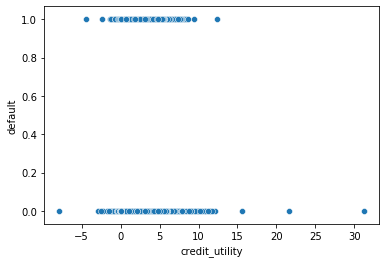

In [18]:
# Create a credit utility category
bills = [
    'bill_amt1',
    'bill_amt2',
    'bill_amt3',
    'bill_amt4',
    'bill_amt5',
    'bill_amt6'
]

payments = [
     'pay_amt1',
     'pay_amt2',
     'pay_amt3',
     'pay_amt4',
     'pay_amt5',
     'pay_amt6',
]

# account balance
account_balance = X_2[bills].sum(axis=1) - X_2[payments].sum(axis=1)
X_2['bill'] = X_2[bills].sum(axis=1)
X_2['account_balance'] = account_balance
# credit utility
X_2['credit_utility'] = account_balance / X_2.limit_bal
X_2
sns.scatterplot(x=X_2.credit_utility, y=y_train);

In [20]:
pd.concat([X_2, y_train], axis=1).sort_values('credit_utility', ascending=True)

,limit_bal,male,age,pay_0,pay_2,pay_3,pay_4,pay_5,pay_6,bill_amt1,...,pay_amt5,pay_amt6,other,post_grad,university,married,bill,account_balance,credit_utility,default
4316,340000,0,42,-1,-1,-1,-1,-1,0,139808,...,20000,145000,0,1,0,0,1092552,-2671514,-7.857394,0
7208,60000,0,31,-1,-1,-1,-1,-1,-1,44912,...,415,50136,0,0,1,1,-496,-268874,-4.481233,1
18806,10000,1,37,-1,-1,-1,0,-1,0,885,...,0,0,0,0,1,0,4700,-28805,-2.880500,0
12473,20000,1,59,1,-1,0,0,-1,-1,-1213,...,39070,25000,0,0,1,1,103392,-50645,-2.532250,0
9055,280000,1,33,-1,-1,-1,-1,-1,-1,898,...,0,345293,0,1,0,0,-336259,-683998,-2.442850,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12320,10000,0,51,0,0,0,0,0,0,53095,...,0,0,0,0,0,0,127104,121348,12.134800,0
9674,20000,1,37,0,0,0,0,0,0,66599,...,649,623,0,1,0,0,255363,247961,12.398050,1
14368,20000,0,26,0,0,0,0,0,0,73404,...,1000,1000,0,0,1,1,320856,310756,15.537800,0
20219,20000,1,30,-1,0,0,0,0,0,82812,...,150,1832,0,1,0,0,451095,431416,21.570800,0


In [29]:
test_df = pd.concat([X_2, y_train], axis=1)#.sort_values('account_balance', ascending=True)

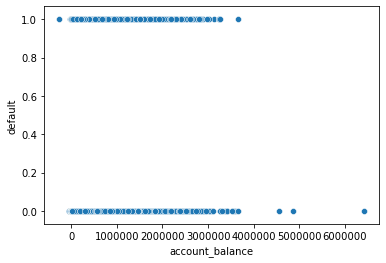

In [23]:
sns.scatterplot(x=X_2.account_balance, y=y_train);

In [31]:
test_df[(test_df.bill < 0) & (test_df.default == 1)].iloc[:5]

,limit_bal,male,age,pay_0,pay_2,pay_3,pay_4,pay_5,pay_6,bill_amt1,...,pay_amt5,pay_amt6,other,post_grad,university,married,credit_utility,account_balance,bill,default
1767,200000,1,34,1,-2,-1,0,0,-2,-1730,...,0,0,0,1,0,0,-0.010280,-2056,-5056,1
11552,340000,1,43,1,-2,-2,-2,-2,-2,-15,...,0,0,0,0,1,1,-0.000265,-90,-90,1
21267,30000,0,24,-1,-1,-1,-1,2,2,165,...,0,5527,0,1,0,0,0.204300,6129,-51,1
5605,360000,0,32,1,-2,-2,-2,-2,-2,-301,...,0,0,0,0,1,1,-0.005017,-1806,-1806,1
12113,140000,0,54,1,-2,-2,-2,-2,-2,-150,...,0,0,0,0,0,1,-0.006429,-900,-900,1


# A side thought

There are individuals where their total bills over the period were net negative. This indicates that they were given credit by the credit card companies or that they over paid. Let's look at the pay column and see if there are any patterns amongst the individuals who were paid money

In [63]:
bills_df = test_df[bills]
negative_bills = bills_df[bills_df < 0].replace(np.nan, 0)
sum_negative_bills = negative_bills.sum(axis=1)
test_df = pd.concat([test_df, sum_negative_bills], axis = 1)


In [69]:
test1_df=pd.concat([test_df, y_train], axis=1)
test1_df[(test1_df[0] != 0)]# & (test1_df.default == 1)]

,limit_bal,male,age,pay_0,pay_2,pay_3,pay_4,pay_5,pay_6,bill_amt1,...,pay_amt5,pay_amt6,other,post_grad,university,married,credit_utility,account_balance,0,default
9737,110000,0,25,-2,-2,-2,-2,-2,-2,-2628,...,5000,0,0,0,1,0,0.628718,69159,-15626.0,0
14148,260000,0,33,-2,-1,-1,-1,0,0,0,...,0,0,0,1,0,0,0.021531,5598,-810.0,0
16290,180000,0,47,1,-2,-1,-1,-2,-1,-6,...,679,421,0,1,0,0,0.023750,4275,-12.0,0
17664,50000,0,24,1,-2,-1,0,0,0,-1037,...,1100,1250,0,0,0,1,4.312300,215615,-2074.0,0
11943,180000,1,49,-1,-1,2,2,-2,-2,1092,...,0,0,0,1,0,1,0.025894,4661,-1302.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1021,150000,1,39,1,-2,-2,-1,-1,-2,-7,...,0,0,0,0,1,1,0.110373,16556,-7.0,0
2612,150000,0,49,1,-2,-1,-1,0,-1,-260,...,2868,4384,1,0,0,0,0.280707,42106,-3095.0,0
14502,230000,0,34,-2,-2,-2,-2,-2,-2,1716,...,0,0,0,0,1,0,-0.014530,-3342,-10003.0,0
3005,20000,1,25,1,-1,-1,0,0,0,-431,...,1000,4000,0,1,0,0,1.060800,21216,-431.0,0


In [37]:
# Categorize limit bal into 4 based on iqr
X_2.limit_bal.describe()

count      16874.000000
mean      166689.562641
std       129474.424792
min        10000.000000
25%        50000.000000
50%       140000.000000
75%       240000.000000
max      1000000.000000
Name: limit_bal, dtype: float64

In [41]:
def limit_bal_tocat(n):
    if n <= 50000:
        return 'low'
    elif  n <= 140000:
        return 'low_mid'
    elif n <= 240000:
        return 'high_mid'
    else:
        return 'high'
    
X_3 = X_2.copy()    
X_3['limit_cat'] = X_3.limit_bal.apply(limit_bal_tocat)
limit_cat_dummies = pd.get_dummies(X_3.limit_cat)
X_3 = pd.concat([X_3, limit_cat_dummies], axis=1)
X_3 = X_3.drop(columns=['limit_cat', 'limit_bal', 'low'])
X_3.head()

,male,age,pay_0,pay_2,pay_3,pay_4,pay_5,pay_6,bill_amt1,bill_amt2,...,pay_amt4,pay_amt5,pay_amt6,other,post_grad,university,married,high,high_mid,low_mid
9737,0,25,-2,-2,-2,-2,-2,-2,-2628,-5118,...,10000,5000,0,0,0,1,0,0,0,1
6325,0,43,2,2,2,2,3,2,13509,13499,...,0,0,1400,0,0,0,0,0,0,0
3410,0,28,0,0,0,0,0,2,42238,38741,...,2500,0,2000,0,0,1,0,0,1,0
2227,0,33,0,0,0,0,-1,0,39554,38600,...,20130,1000,1000,0,0,1,1,0,0,0
6715,1,47,0,0,0,0,0,0,91481,47099,...,1000,1000,1000,0,0,1,0,0,0,0


In [60]:
# Categorize age based on iqr
X_3.age.describe()

def age_tocat(n):
    if n <= 28:
        return 'young'
    elif  n <= 34:
        return 'young_mid'
    elif n <= 41:
        return 'old_mid'
    else:
        return 'old'

X_4 = X_3.copy()
age_cat = X_4.age.apply(age_tocat)
age_cat_dummies = pd.get_dummies(age_cat)
X_4 = pd.concat([X_4, age_cat_dummies], axis=1)
X_4.drop(columns=['age', 'young'], inplace=True)

In [ ]:
# credit the credit utilization column
bills = [
    'bill_amt1',
    'bill_amt2',
    'bill_amt3',
    'bill_amt4',
    'bill_amt5',
    'bill_amt6'
]

payments = [
     'pay_amt1',
     'pay_amt2',
     'pay_amt3',
     'pay_amt4',
     'pay_amt5',
     'pay_amt6',
]

account_balance = X_4.limit_bal - df1[bills].sum(axis=1) + df1[payments].sum(axis=1)
df1['account_balance'] = account_balance

# credit utility
df1['credit_utility'] = df1['account_balance'] / df1.limit_bal *100

In [ ]:
# Run through 100 
c_values = list(np.linspace(0.01, 1, 100))
models = [LogisticRegression(penalty='l1', C=value, solver='saga') for value in c_values]

fit = [model.fit(X_train, y_train) for model in models]

predictions = [model.predict(X_test) for model in fit]

auc = [metrics.roc_auc_score(y_test, prediction) for prediction in predictions]

all_the_things = sorted(list(zip([x for x in c_values], auc)), key=lambda x: x[1], reverse=True)
all_the_things

# Grid search for a random forest on my data

In [10]:
decision_tree = DecisionTreeClassifier(random_state=1)

# creating our parameters to test
param_dict={
    'max_depth': range(1,10,1),
    'min_samples_leaf': range(1,6,1),
    'max_leaf_nodes': [None, 17,20,15],
    'min_samples_split': range(2,10, 1)
}


grid_tree=GridSearchCV(decision_tree,
                       param_grid = param_dict,
                       cv=10, 
                       scoring='f1',
                       verbose=1,
                       n_jobs=-1
                      )

grid_tree.fit(X_train,y_train);

Fitting 10 folds for each of 1440 candidates, totalling 14400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
/Users/TjH/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/externals/joblib/numpy_pickle.py:104: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  pickler.file_handle.write(chunk.tostring('C'))
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:    5.4s
[Parallel(n_jobs=-1)]: Done 345 tasks      | elapsed:   12.6s
[Parallel(n_jobs=-1)]: Done 845 tasks      | elapsed:   26.3s
[Parallel(n_jobs=-1)]: Done 1545 tasks      | elapsed:   49.0s
[Parallel(n_jobs=-1)]: Done 2445 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 3545 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done 4845 tasks      | elapsed:  3.2min
[Parallel(n_jobs=-1)]: Done 5870 tasks      | elapsed:  4.3min
[Parallel(n_jobs=-1)]: Done 6720 tasks      | elapsed:  5.3min
[Parallel(n_jobs=-1)]: Done 7670 tasks      | elapsed:  6.3min
[Parallel(n_jobs=-1)]: Done 8720 tasks      | elapsed:  7.6min
[P

KeyboardInterrupt: 

In [ ]:
# Single best score achieved across all params (min_samples_split)
print(grid_tree.best_score_)

# Dictionary containing the parameters (min_samples_split) used to generate that score
print(grid_tree.best_params_)

# Actual model object fit with those best parameters
# Shows default parameters that we did not specify
print(grid_tree.best_estimator_)